# Img2Emotion

This is a second attempt at implementing a model that takes as input an image of a face and returns the current gesture or emotion



In [1]:
import numpy as np
from PIL import Image
import os
import shutil
import torch, torchvision

%matplotlib inline

### Convert the data to usable data

The data was stored initially on a usb as multiple csv files. This script will read the data and transform it into label-folder style

In [2]:
path = '/Volumes/JON SNOW' #USB path, where csv files live
train_path = 'train'
expected_size = 4096
x_list = []
y_list = []

# First check if train folder exists, if so, terminate.
if os.path.exists(train_path) == False:

    # Get all the files in which the data is stored
    # This files have the format x_data0.csv, x_data1.csv, y_data0.csv, y_data1.csv, etc
    for i in os.listdir(path):
        if os.path.isfile(os.path.join(path, i)):
            if 'x_data' in i:
                x_list.append(i)
            if 'y_data' in i:
                y_list.append(i)

    x_list = sorted(x_list)
    y_list = sorted(y_list)

    print(x_list)
    print(y_list)

    for f_i in range(len(x_list)):
        print(f"Reading file n.{f_i}: {x_list[f_i]}")
        # Iterate over all files
        x_path = os.path.join(path, x_list[f_i])
        y_path = os.path.join(path, y_list[f_i])

        x = open(x_path)
        y = open(y_path)

        success = None
        while success is None:
            try:
                data = x.readline()
                label = y.readline()

                success = True
            except:
                pass

        while data:
            data = data.strip() # Remove newline

            label = label.strip() # Remove newline
            array = np.fromstring(data, sep=",")

            # Check if data is corrupted
            if array.shape[0] == expected_size:
                array = array.reshape((64,64))
                im = Image.fromarray(array).convert("L") # Convert to grayscale img

                label = os.path.join(train_path, label)
                # Create label directory if doesn't exists
                if not os.path.exists(label):
                    os.makedirs(label)

                # Get number of elements in label directory to assign name to next image
                _, _, files = next(os.walk(label))
                im_name = str(len(files))+'.jpeg'

                # Store image
                im.save(os.path.join(label, im_name))

            # read next line for data and label
            success = None
            while success is None:
                try:
                    data = x.readline()
                    label = y.readline()

                    success = True
                except:
                    pass

        x.close()
        y.close()
    print("Completed!")

### Split the dataset

Once the data is correctly organized, move a percentage of it into testing  dataset

In [3]:
test_path = "test"
percentage = 0.1

if os.path.exists(test_path) == False:
    for i in os.listdir(train_path):
        if not os.path.exists(os.path.join(test_path, i)):
            os.makedirs(os.path.join(test_path, i))

        files =  sorted(os.listdir(os.path.join(train_path, i)))
        size = int(len(files)*percentage)
        rand_files = np.random.choice(files, size, replace=False)
        for file in rand_files:
            shutil.move(os.path.join(train_path, i, file), os.path.join(test_path, i, file))

### Get the Data:

Data is stored in the folders `./train` and `./test`, with folder containing images, and the folder names are their labels

In [276]:
from torchvision import transforms, datasets

transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomPerspective(),
                                transforms.RandomRotation(90),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))
                                ])

test_transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,))
                                    ])

trainset = datasets.ImageFolder(root='./train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.ImageFolder(root='./test', transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [277]:
data, labels = next(iter(trainloader))
print(data.shape)

torch.Size([64, 3, 64, 64])


### Build the model

Since this are images, the model will be based on convolutions, and a final densely connected layer

In [278]:
from torch import nn, optim
import torch.nn.functional as F

class FaceClassifier(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        
        # Input shape is (3,64,64)
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Output shape is (6,32,32)
        
        # Input shape is (6,32,32)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Output shape is (12, 16, 16)
        
        self.fc1 = nn.Linear(12 * 16 * 16, 64)
        
        self.fc2 = nn.Linear(64, 6)
        
        # Add Dropout
        self.dropout = nn.Dropout(p=p)
        
    def forward(self, x):
        # Compute activation of first conv layer
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.pool1(x)

        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool2(x)
        
        # reshape the data for fc layers
        x = x.view(-1, 12 * 16 * 16)
        
        x = self.dropout(F.relu(self.fc1(x)))
        
        # Get the log softmax output
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x
        
        

### Train and save the model

Train for 30 epochs and store the model. If a checkpoint exists, then don't train

In [340]:
model = FaceClassifier(0.2)

In [342]:
retrain = True # Whether we want to retrain a model even if a checkpoint exists

if os.path.exists('checkpoint.pth') == False or retrain:
    
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    epochs = 10
    steps = 0
    train_losses, test_losses = [],[]

    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            model.train()

            optimizer.zero_grad()

            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            steps += 1
            
            if steps % 10 == 0:
                model.eval()
                with torch.no_grad():
                    images, labels = next(iter(testloader))
                    ps = torch.exp(model(images))
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy = torch.mean(equals.type(torch.FloatTensor))
                print(f'Epoch: {e}/{epochs} | Loss: {np.round(running_loss/steps+1, 3)} | Accuracy: {np.round(accuracy.item()*100, 3)}%')
                torch.save(model.state_dict(), 'checkpoint.pth')

Epoch: 0/10 | Loss: 2.759 | Accuracy: 20.312%
Epoch: 0/10 | Loss: 2.752 | Accuracy: 17.188%
Epoch: 0/10 | Loss: 2.749 | Accuracy: 32.812%
Epoch: 0/10 | Loss: 2.743 | Accuracy: 28.125%
Epoch: 0/10 | Loss: 2.736 | Accuracy: 29.688%
Epoch: 0/10 | Loss: 2.734 | Accuracy: 35.938%
Epoch: 0/10 | Loss: 2.727 | Accuracy: 32.812%
Epoch: 0/10 | Loss: 2.721 | Accuracy: 46.875%
Epoch: 0/10 | Loss: 2.711 | Accuracy: 32.812%
Epoch: 0/10 | Loss: 2.706 | Accuracy: 34.375%
Epoch: 0/10 | Loss: 2.704 | Accuracy: 39.062%
Epoch: 0/10 | Loss: 2.698 | Accuracy: 37.5%
Epoch: 0/10 | Loss: 2.692 | Accuracy: 31.25%
Epoch: 0/10 | Loss: 2.686 | Accuracy: 40.625%
Epoch: 0/10 | Loss: 2.682 | Accuracy: 42.188%
Epoch: 1/10 | Loss: 1.019 | Accuracy: 48.438%
Epoch: 1/10 | Loss: 1.109 | Accuracy: 31.25%
Epoch: 1/10 | Loss: 1.192 | Accuracy: 43.75%
Epoch: 1/10 | Loss: 1.265 | Accuracy: 31.25%
Epoch: 1/10 | Loss: 1.329 | Accuracy: 31.25%
Epoch: 1/10 | Loss: 1.389 | Accuracy: 43.75%
Epoch: 1/10 | Loss: 1.444 | Accuracy: 48.4

### Restore the model

In [349]:
state_dict = torch.load('checkpoint.pth copy')
model = FaceClassifier()
model.load_state_dict(state_dict)
model.eval()

FaceClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
  (dropout): Dropout(p=0.2)
)

### Visualize results

Let's run the model with some of the test images and check it's prediction

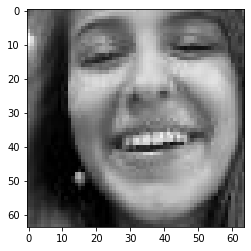

Predict: happy | 85% | True: happy


In [350]:
import matplotlib.pyplot as plt

classes = ['neutral','happy','surprise','angry','sad','disgust']


idx = np.random.randint(len(testset))
image, label = testset.__getitem__(idx)
image = image.unsqueeze(0)

ps = torch.exp(model(image))
top_p, top_class = ps.topk(1, dim=1)

image = (image+1)/2
plt.imshow(np.rollaxis(image.numpy().squeeze(),0,3))
plt.show()

print(f"Predict: {classes[top_class.item()]} | {int(top_p.item()*100)}% | True: {classes[label]}")

## Detect faces from default camera

Now let's use OpenCV to detect faces from our default camrea stream

In [351]:
import cv2, time, face_recognition
from PIL import Image

# Create an object. Zero for external camera
video = cv2.VideoCapture(0)
cv2.startWindowThread()
scale = 0.25

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))
                                ])

# Start face recognition algorithm
face_cascade = cv2.CascadeClassifier('/anaconda3/envs/jupyter/lib/python3.7/site-packages/cv2/data/haarcascade_frontalface_default.xml')
while True:
    # Create a frame object
    check, frame = video.read()


    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    width = int(gray.shape[1]*scale)
    height = int(gray.shape[0]*scale)
    
    small_gray = cv2.resize(gray, (width, height), interpolation=cv2.INTER_AREA)
    
    # Look for faces
    # faces = face_cascade.detectMultiScale(gray, 2, 5)
    faces = face_recognition.face_locations(small_gray)
    
    # Insert face locations in frame
    for (top,right,bottom,left) in faces:
        # rescale for drawing
        top = int(top*(1/scale))
        right = int(right*(1/scale))
        bottom = int(bottom*(1/scale))
        left = int(left*(1/scale))
        cv2.rectangle(frame,(left, top), (right, bottom), (255,0,0), 2)
        
        # Extract faces and predict an emotion
        face = gray[top:bottom, left:right]
        face = cv2.resize(face, (64,64), interpolation=cv2.INTER_AREA)
        # face = np.array([face, face, face])
        face = Image.fromarray(face.astype(np.uint8))
        face = transform(face)
        face = torch.cat((face,)*3, 0)
        
        with torch.no_grad():
            ps = torch.exp(model(face.unsqueeze(0)))
            top_p, top_class = ps.topk(1, dim=1)
        emotion = classes[top_class]
        text = f"{int(top_p.item()*100)}% | {emotion}"
        
        # Draw a label with the emotion predicted
        cv2.rectangle(frame, (left, bottom-25), (right, bottom), (255,0,0), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, text, (left + 6, bottom - 6), font, 0.5, (255,255,255), 1)
        
    cv2.imshow("Camera", frame)

    key=cv2.waitKey(1)
    
    if key == ord('q'):
        break

    # Shutdown the camera
video.release()
cv2.waitKey(1)
cv2.destroyWindow("Camera")
cv2.waitKey(1)

-1